In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Set style 
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"]=(12,6)


In [6]:
#Load data
import requests

url = r"https://www.unsiap.or.jp/on_line/ML/M6-clean_data.csv"
r = requests.get(url, stream = True, verify=False)
r.raise_for_status()
with open ("M6-clean_data.csv", "wb") as  f:
    f.write(r.content)
    

In [7]:
# Display the first few rows
df = pd.read_csv("M6-clean_data.csv")
print(df.head())

   price  host_is_superhost neighborhood  latitude  longitude property_type  \
0    225              False       M-Zone  40.75362  -73.98377    Appartment   
1    200              False       M-Zone  40.74767  -73.97500    Appartment   
2     60              False       A-Zone  40.68688  -73.95596    Appartment   
3     79              False       M-Zone  40.76489  -73.98493    Appartment   
4     79              False       M-Zone  40.80178  -73.96723    Appartment   

   accommodates  bedrooms  beds  cleaning_fee  minimum_nights  \
0             2         0     1            95               3   
1             2         1     1           125               3   
2             2         1     1             0              29   
3             2         1     1            15               2   
4             1         1     1             0               2   

   availability_365  review_scores_rating cancellation_policy  
0               365                  94.0              strict  
1     

In [13]:
#Data Exploration
print("Data Shape:", df.shape)
print("Data info:\n", pd.DataFrame(df.info()))
print("Numerical summary:\n", pd.DataFrame(df.describe().T))

Data Shape: (48751, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48751 entries, 0 to 48750
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 48751 non-null  int64  
 1   host_is_superhost     48751 non-null  bool   
 2   neighborhood          48751 non-null  object 
 3   latitude              48751 non-null  float64
 4   longitude             48751 non-null  float64
 5   property_type         48751 non-null  object 
 6   accommodates          48751 non-null  int64  
 7   bedrooms              48751 non-null  int64  
 8   beds                  48751 non-null  int64  
 9   cleaning_fee          48751 non-null  int64  
 10  minimum_nights        48751 non-null  int64  
 11  availability_365      48751 non-null  int64  
 12  review_scores_rating  48751 non-null  float64
 13  cancellation_policy   48751 non-null  object 
dtypes: bool(1), float64(3), int64(7), object(3)
me

In [20]:
# Target variable is price first cloumn
target_col = "price"
# Seperate features and target
X = df.drop(columns=[target_col])
y = df[target_col]
print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (48751, 13)
Target shape: (48751,)


In [21]:
#Categorical data selection on conversion
#Identify different types or variables
numeric_features = X.select_dtypes(include =[np.number]).columns.tolist()
boolean_features = X.select_dtypes(include = ["bool"]).columns.tolist()
categorical_features = X.select_dtypes(include =["object"]).columns.tolist()

In [22]:
print(f"Numeric features: { len(numeric_features)}" )
print(f"Boolean featrues: {len(boolean_features)}")
print(f"Categorical features: {len(categorical_features)}")


Numeric features: 9
Boolean featrues: 1
Categorical features: 3


In [23]:
# Analyze the categorical features
if len(categorical_features)> 0:
    print("\n Categorical features analysis:")
    for col in categorical_features:
        n_unique = X[col].nunique()
        print(f" {col}: {n_unique} unique values - {X[col].unique()[:n_unique]}")



 Categorical features analysis:
 neighborhood: 5 unique values - ['M-Zone' 'A-Zone' 'Q-Zone' 'S-Zone' 'B-Zone']
 property_type: 3 unique values - ['Appartment' 'House' 'PrivateRoom']
 cancellation_policy: 3 unique values - ['strict' 'moderate' 'flexible']


In [24]:
#Analyze the boolean features
if len(boolean_features)>0:
    for col in boolean_features:
        print(f" {col}: {X[col].value_counts().to_dict()}")

 host_is_superhost: {False: 39055, True: 9696}


In [25]:
#Encode categorical and boolean variables
#Encode boolean to 0,1 
X_encoded = X.copy()
if len(boolean_features)>0:
    print(f"Converting {len(boolean_features)} boolean features to numeric...")
    for col in boolean_features:
        X_encoded[col] = X_encoded[col].astype(int)
        print(f"{col} is converted to numeric 0, 1")

Converting 1 boolean features to numeric...
host_is_superhost is converted to numeric 0, 1


In [26]:
#One hot encode  categorical variables
if len(categorical_features)>0:
    print(f"One-hot encoding {len(categorical_features)} categorical features will be converted")
    X_encoded = pd.get_dummies(X_encoded, columns = categorical_features, drop_first=True)
    print(f"After encoding: {X_encoded.shape[1]} features")
    print(f"New features added {X_encoded.shape[1]-X.shape[1]}")

One-hot encoding 3 categorical features will be converted
After encoding: 18 features
New features added 5


In [27]:
#update all feature list
all_features =X_encoded.columns.tolist()
print(f"Total featueres after encoing : {len(all_features)}")

Total featueres after encoing : 18


In [28]:
# Categorical variables summary
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical Variables:")
for col in categorical_cols:
    print(f"\n{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head())


Categorical Variables:

neighborhood: 5 unique values
M-Zone    21778
A-Zone    19604
Q-Zone     5859
B-Zone     1149
S-Zone      361
Name: neighborhood, dtype: int64

property_type: 3 unique values
Appartment     41746
House           5702
PrivateRoom     1303
Name: property_type, dtype: int64

cancellation_policy: 3 unique values
strict      21888
flexible    15540
moderate    11323
Name: cancellation_policy, dtype: int64


In [30]:
for data in X.columns:
    print(X[data].isnull().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0


<Axes: ylabel='Density'>

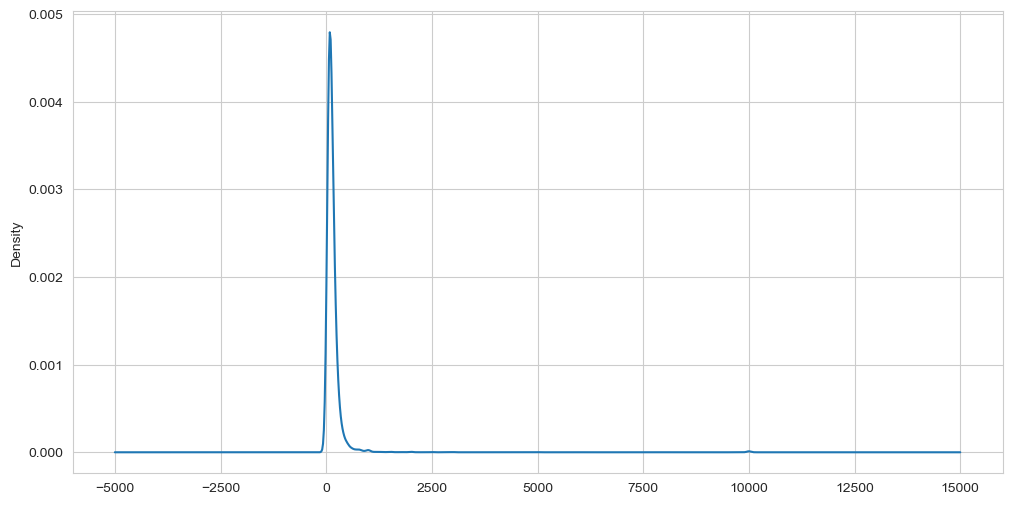

In [31]:
y.plot.kde()

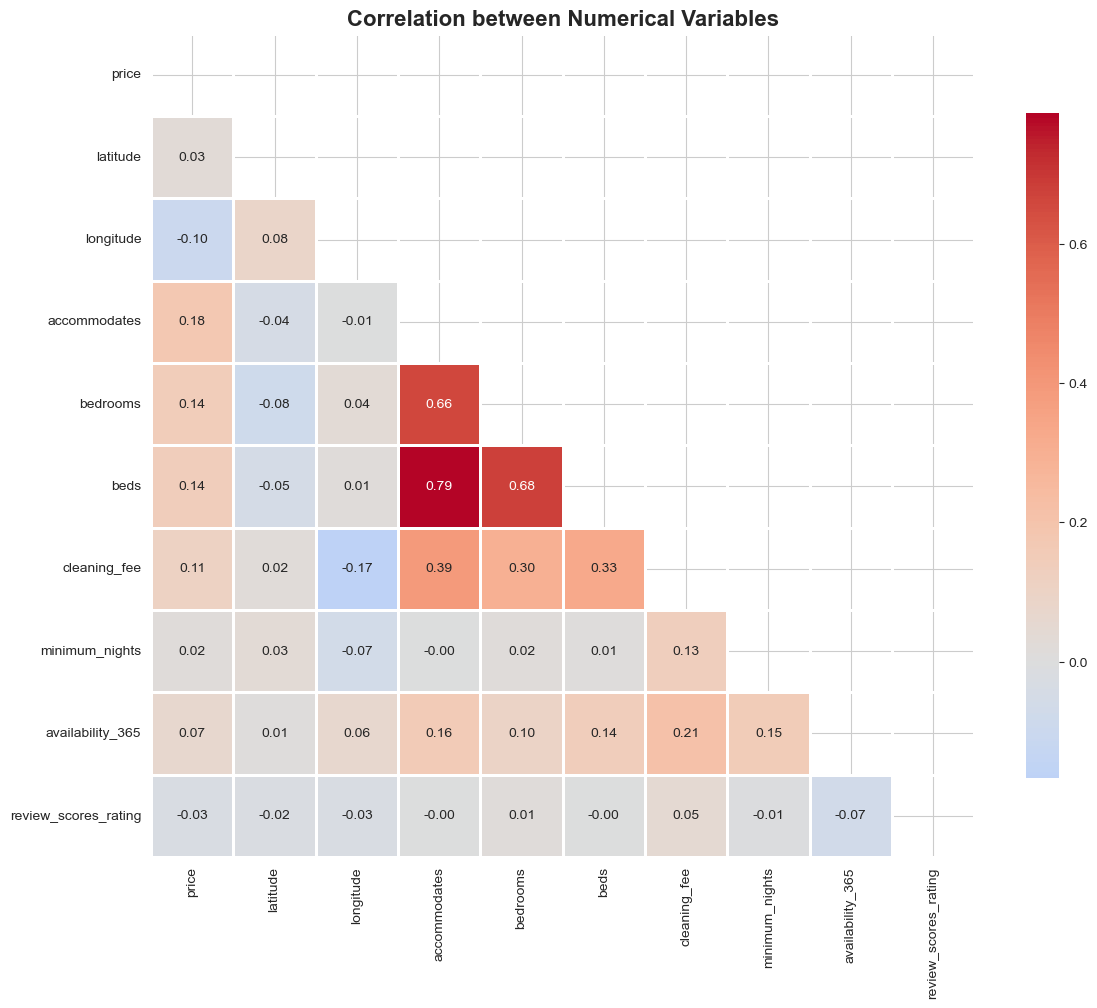

In [33]:
# Correlation matrix for numerical variables
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
# Visualize correlation
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, 
            linewidths=1, cbar_kws={"shrink": .8})
plt.title('Correlation between Numerical Variables', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation Guidelines:
* High correlation with price: Variables like accommodates, bedrooms, bathrooms likely show strong positive correlation
* Multicollinearity concerns: If bedrooms and accommodates are highly correlated (>0.8), this could affect model interpretation
* Unexpected patterns: Low correlation with price might indicate non-linear relationships
* Feature engineering opportunity: Consider creating interaction terms or polynomial features

### Data Preprocessing & Model Training

In [34]:
X = X_encoded
X.head()

,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,cleaning_fee,minimum_nights,availability_365,review_scores_rating,neighborhood_B-Zone,neighborhood_M-Zone,neighborhood_Q-Zone,neighborhood_S-Zone,property_type_House,property_type_PrivateRoom,cancellation_policy_moderate,cancellation_policy_strict
0,0,40.75362,-73.98377,2,0,1,95,3,365,94.0,0,1,0,0,0,0,0,1
1,0,40.74767,-73.97500,2,1,1,125,3,0,90.0,0,1,0,0,0,0,1,0
2,0,40.68688,-73.95596,2,1,1,0,29,365,90.0,0,0,0,0,0,0,0,1
3,0,40.76489,-73.98493,2,1,1,15,2,272,84.0,0,1,0,0,0,0,0,1
4,0,40.80178,-73.96723,1,1,1,0,2,0,98.0,0,1,0,0,0,0,0,0


In [35]:
#train-test split (50-50 a)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=455)

In [36]:
#Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
#Lasso with cross-validation
#LassoCV with 5-fold cross validation find the alpha
lasso_cv = LassoCV(alphas = np.linspace(0.0001, 0.003, 5),
                 cv = 5,
                 random_state = 123,
                 max_iter = 10000)
lasso_cv.fit(X_train_scaled, y_train)

,eps,0.001
,n_alphas,'deprecated'
,alphas,"array([0.0001...75, 0.003 ])"
,fit_intercept,True
,precompute,'auto'
,max_iter,10000
,tol,0.0001
,copy_X,True
,cv,5
,verbose,False
,n_jobs,None


In [40]:
#Best lambda value 
print(f"Best alpha (lambda):{lasso_cv.alpha_:.6f}")

Best alpha (lambda):0.003000


In [41]:
#predictions
y_pred_laso = lasso_cv.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_laso))
print(f"LASSO RMSE: {rmse_lasso:.4f}")

LASSO RMSE: 446.3976


### Feature Selection Analysis

In [45]:
#Get Coefficients and identify important features
lasso_coef = pd.DataFrame({
    "feature": X_encoded.columns,
    "coefficient":lasso_cv.coef_
})

lasso_coef = lasso_coef[lasso_coef["coefficient"] !=0].sort_values("coefficient", key =abs, ascending = False)
lasso_coef

,feature,coefficient
15,property_type_PrivateRoom,58.847698
3,accommodates,58.316412
11,neighborhood_M-Zone,36.912888
2,longitude,-35.055774
4,bedrooms,30.675681
17,cancellation_policy_strict,-18.979071
13,neighborhood_S-Zone,-15.568293
5,beds,-14.783661
6,cleaning_fee,13.150052
16,cancellation_policy_moderate,-13.083638


In [47]:
print(f"Number of selected features: {len(lasso_coef)} out of {len(X_encoded.columns)}")
print(f"Top 10 Important Features:")
print(lasso_coef.head(10))

Number of selected features: 18 out of 18
Top 10 Important Features:
                         feature  coefficient
15     property_type_PrivateRoom    58.847698
3                   accommodates    58.316412
11           neighborhood_M-Zone    36.912888
2                      longitude   -35.055774
4                       bedrooms    30.675681
17    cancellation_policy_strict   -18.979071
13           neighborhood_S-Zone   -15.568293
5                           beds   -14.783661
6                   cleaning_fee    13.150052
16  cancellation_policy_moderate   -13.083638


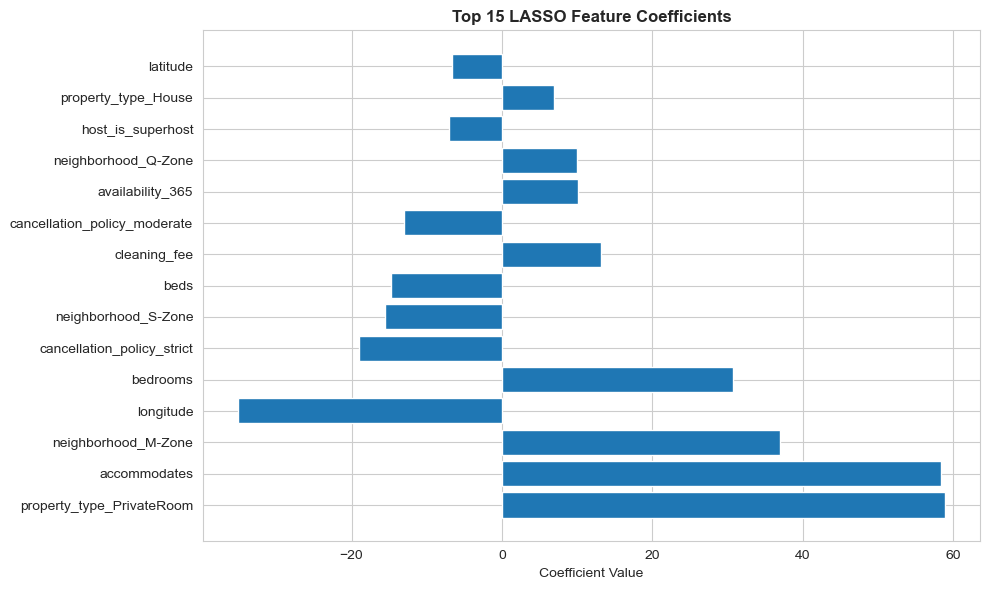

In [51]:
#visualize feature coefficients
plt.figure(figsize=(10, 6))
top_features = lasso_coef.head(15)
plt.barh(top_features["feature"], top_features["coefficient"])
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Coefficient Value")
plt.title("Top 15 LASSO Feature Coefficients", fontweight="bold")
plt.tight_layout()
plt.show()

In [56]:
top_features["feature"].to_list()

['property_type_PrivateRoom',
 'accommodates',
 'neighborhood_M-Zone',
 'longitude',
 'bedrooms',
 'cancellation_policy_strict',
 'neighborhood_S-Zone',
 'beds',
 'cleaning_fee',
 'cancellation_policy_moderate',
 'availability_365',
 'neighborhood_Q-Zone',
 'host_is_superhost',
 'property_type_House',
 'latitude']

### 📈 LASSO Interpretation:
* Variable selection: LASSO automatically sets some coefficients to exactly zero, performing feature selection
* Coefficient magnitude: Larger absolute values indicate stronger effects on price
* Sign interpretation: Positive = increases price, Negative = decreases price
* Multicollinearity handling: LASSO helps deal with correlated predictors by selecting one over others
* Model simplicity: Fewer non-zero coefficients = more interpretable model

### Random Forest Model Training
X_train_scaled is a NumPy array

In [63]:
# Based on the LASSO results, select important features
#Example : Using top features identified by lASSO
select_f = top_features["feature"].to_list()
# Suppose you scaled X_train (a DataFrame)
feature_names = X_train.columns   # original feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_train_scaled = X_train_scaled[select_f]


,property_type_PrivateRoom,accommodates,neighborhood_M-Zone,longitude,bedrooms,cancellation_policy_strict,neighborhood_S-Zone,beds,cleaning_fee,cancellation_policy_moderate,availability_365,neighborhood_Q-Zone,host_is_superhost,property_type_House,latitude
32376,-0.166304,-0.463471,-0.892175,-0.276004,-1.549315,1.098854,-0.090034,-0.485565,0.676278,-0.546773,0.481969,-0.37035,1.986258,-0.361629,-0.326744
27057,-0.166304,0.068959,1.120856,-0.318685,-0.241588,1.098854,-0.090034,0.451022,1.442752,-0.546773,1.737133,-0.37035,-0.503459,-0.361629,1.192427
28150,-0.166304,-0.463471,-0.892175,-0.812347,-0.241588,-0.910039,-0.090034,-0.485565,-0.856671,-0.546773,-0.858774,-0.37035,-0.503459,-0.361629,-0.468930
4785,-0.166304,-0.463471,1.120856,-0.836946,-1.549315,1.098854,-0.090034,-0.485565,-0.090197,-0.546773,-0.858774,-0.37035,-0.503459,-0.361629,-0.271929
13673,-0.166304,0.601390,1.120856,-0.821809,-0.241588,1.098854,-0.090034,0.451022,-0.105526,-0.546773,-0.858774,-0.37035,-0.503459,-0.361629,0.567946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6239,-0.166304,-0.995902,1.120856,-0.903595,-0.241588,1.098854,-0.090034,-0.485565,-0.856671,-0.546773,-0.858774,-0.37035,-0.503459,-0.361629,0.494002
9243,-0.166304,-0.463471,1.120856,0.033902,-1.549315,-0.910039,-0.090034,-0.485565,-0.856671,1.828912,-0.858774,-0.37035,-0.503459,-0.361629,0.926448
39304,-0.166304,0.068959,-0.892175,-0.066387,1.066140,-0.910039,-0.090034,0.451022,-0.856671,1.828912,-0.281113,-0.37035,-0.503459,-0.361629,-1.017259
10661,-0.166304,-0.463471,-0.892175,0.160471,-0.241588,1.098854,-0.090034,0.451022,-0.090197,-0.546773,-0.216929,-0.37035,-0.503459,-0.361629,-0.434166


In [65]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)
X_test_scaled = X_test_scaled[select_f]
X_test_scaled

,property_type_PrivateRoom,accommodates,neighborhood_M-Zone,longitude,bedrooms,cancellation_policy_strict,neighborhood_S-Zone,beds,cleaning_fee,cancellation_policy_moderate,availability_365,neighborhood_Q-Zone,host_is_superhost,property_type_House,latitude
13283,-0.166304,-0.463471,1.120856,-0.246780,-0.241588,1.098854,-0.090034,-0.485565,-0.090197,-0.546773,0.588943,-0.370350,1.986258,-0.361629,1.238412
23415,-0.166304,0.601390,1.120856,-0.873319,-1.549315,-0.910039,-0.090034,0.451022,-0.856671,1.828912,-0.858774,-0.370350,-0.503459,-0.361629,-0.045130
37404,-0.166304,-0.463471,-0.892175,1.183118,-0.241588,1.098854,-0.090034,-0.485565,-0.243491,-0.546773,1.744264,2.700151,-0.503459,2.765264,0.197856
40200,-0.166304,-0.463471,-0.892175,-0.779128,-0.241588,1.098854,-0.090034,-0.485565,-0.703376,-0.546773,1.651553,-0.370350,1.986258,-0.361629,-2.227409
43467,-0.166304,0.068959,1.120856,-0.565726,1.066140,-0.910039,-0.090034,0.451022,1.289458,1.828912,-0.851642,-0.370350,-0.503459,-0.361629,0.305462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39883,-0.166304,-0.463471,1.120856,-0.648354,-1.549315,1.098854,-0.090034,-0.485565,1.442752,-0.546773,-0.024375,-0.370350,-0.503459,-0.361629,-0.066099
20400,-0.166304,0.068959,1.120856,0.512426,-0.241588,-0.910039,-0.090034,-0.485565,-0.090197,1.828912,-0.730405,-0.370350,1.986258,-0.361629,2.542371
5981,-0.166304,-0.463471,1.120856,0.233217,-0.241588,1.098854,-0.090034,-0.485565,2.209227,-0.546773,-0.858774,-0.370350,1.986258,-0.361629,1.368091
40474,-0.166304,-0.995902,-0.892175,-1.243777,-0.241588,-0.910039,-0.090034,-0.485565,-0.856671,-0.546773,-0.216929,-0.370350,-0.503459,2.765264,-1.428184


In [67]:
# Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=100, 
random_state=42,
max_depth = 10,
min_samples_split = 5,
min_samples_leaf = 3,
n_jobs= -1)# use all CPU cores

In [70]:
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf:.4f}")

Random Forest RMSE: 394.2916


### Feature Importance



Feature Importance:
                         feature  importance
3                      longitude    0.354520
14                      latitude    0.281210
10              availability_365    0.104997
1                   accommodates    0.049296
7                           beds    0.044055
0      property_type_PrivateRoom    0.043212
4                       bedrooms    0.041076
8                   cleaning_fee    0.035672
2            neighborhood_M-Zone    0.031299
9   cancellation_policy_moderate    0.007689
5     cancellation_policy_strict    0.004234
13           property_type_House    0.001910
12             host_is_superhost    0.000788
11           neighborhood_Q-Zone    0.000041
6            neighborhood_S-Zone    0.000002


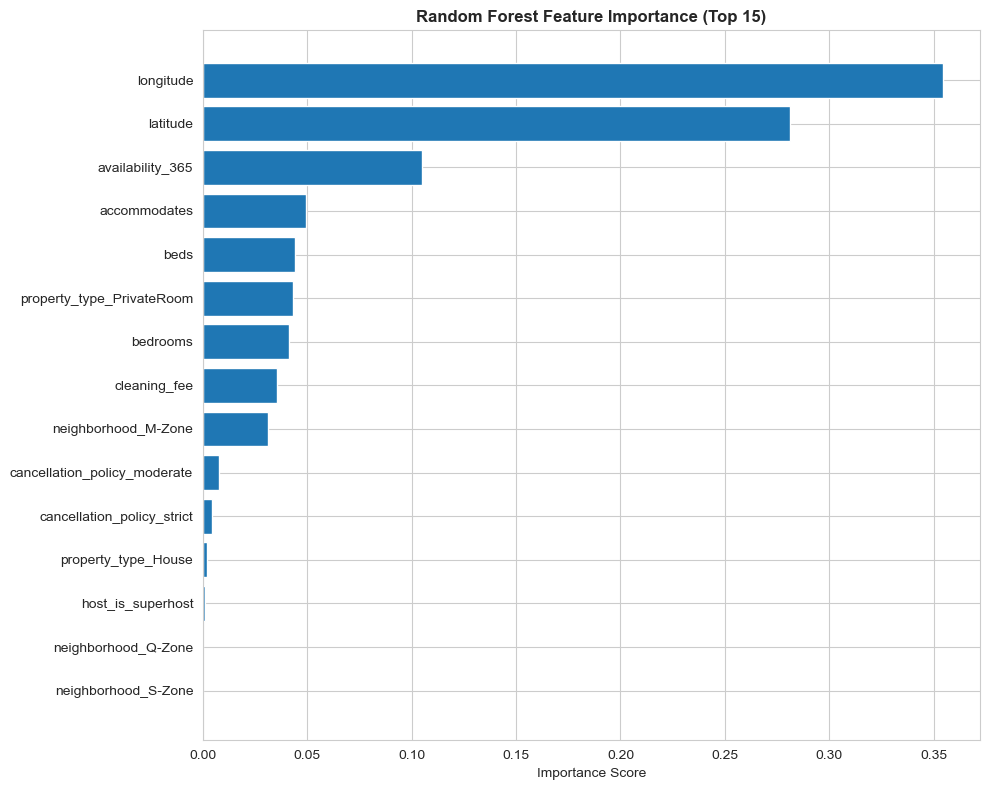

In [74]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'].head(15), 
         feature_importance['importance'].head(15))
plt.xlabel('Importance Score')
plt.title('Random Forest Feature Importance (Top 15)', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 🎲 Random Forest Interpretation:
* Feature importance: Measured by how much each feature decreases impurity across all trees
* Non-linear relationships: RF captures complex interactions that linear models miss
* Robustness: Less sensitive to outliers and doesn't require feature scaling
* Black box nature: Harder to interpret individual predictions compared to LASSO
* Overfitting risk: With too many trees or depth, model may memorize training data

In [75]:
# Cross-validation for robust comparison
from sklearn.model_selection import cross_val_score

# LASSO Cross-validation scores
lasso_cv_scores = -cross_val_score(
    lasso_cv, X_train_scaled, y_train, 
    cv=5, scoring='neg_root_mean_squared_error'
)

# Random Forest Cross-validation scores
rf_cv_scores = -cross_val_score(
    rf_model, X_train_scaled, y_train,
    cv=5, scoring='neg_root_mean_squared_error'
)

# Summary statistics
print("LASSO CV RMSE:")
print(f"  Mean: {lasso_cv_scores.mean():.4f}")
print(f"  Std:  {lasso_cv_scores.std():.4f}")
print(f"\nRandom Forest CV RMSE:")
print(f"  Mean: {rf_cv_scores.mean():.4f}")
print(f"  Std:  {rf_cv_scores.std():.4f}")

LASSO CV RMSE:
  Mean: 343.5571
  Std:  92.9232

Random Forest CV RMSE:
  Mean: 309.2124
  Std:  82.6505


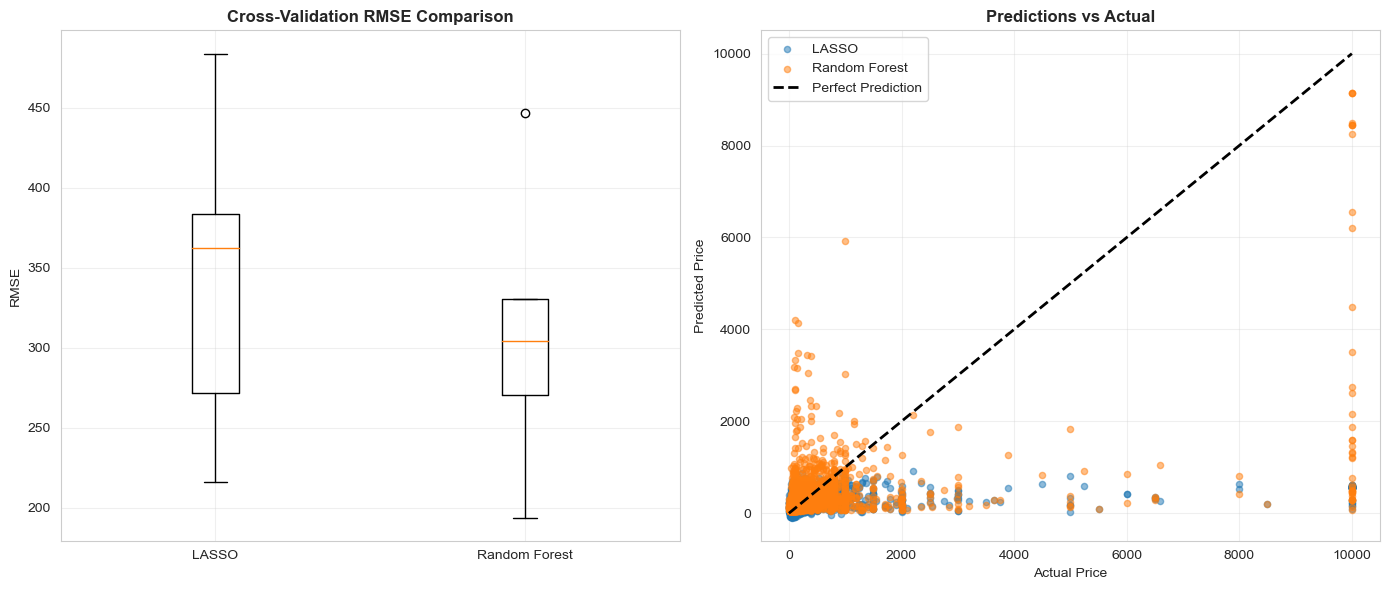

In [77]:
# Comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.boxplot([lasso_cv_scores, rf_cv_scores], 
            labels=['LASSO', 'Random Forest'])
ax1.set_ylabel('RMSE')
ax1.set_title('Cross-Validation RMSE Comparison', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Prediction vs Actual
ax2.scatter(y_test, y_pred_laso, alpha=0.5, label='LASSO', s=20)
ax2.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest', s=20)
ax2.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'k--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Price')
ax2.set_ylabel('Predicted Price')
ax2.set_title('Predictions vs Actual', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### ✅ LASSO Advantages
* Feature selection built-in
* Highly interpretable
* Fast to train
* Handles multicollinearity 

### ✅ Random Forest Advantages
* Captures non-linear patterns
* Handles interactions automatically
* Robust to outliers
* Often higher accuracy

### 📝 Final Recommendations
1. Use LASSO for initial variable selection and understanding key drivers
2. Use Random Forest for final predictions if accuracy is paramount
3. Consider ensemble approaches combining both models
4. Always validate with cross-validation, not just single train-test split
5. Document feature importance and model limitations